In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import cv2
from keras.models import load_model
%matplotlib inline


## Load Data

In [3]:
# get ids and labels of the train images
train_labels = pd.read_csv("../input/arabic-hwr-ai-pro-intake1/train.csv")
train_labels =train_labels.set_index("id")
train_labels.head()

,label
id,
0,24
1,2
2,17
3,14
4,19


In [4]:
train_labels.value_counts()

label
1        480
2        480
27       480
26       480
25       480
24       480
23       480
22       480
21       480
20       480
19       480
18       480
17       480
16       480
15       480
14       480
13       480
12       480
11       480
10       480
9        480
8        480
7        480
6        480
5        480
4        480
3        480
28       480
dtype: int64

The dataset is perfectly balanced with each letter has 480 training examples

In [5]:
# get ids of the test images
test_ids = pd.read_csv("../input/arabic-hwr-ai-pro-intake1/test.csv")
test_ids.head()

,id
0,0
1,1
2,2
3,3
4,4


In [6]:
# load train images and there corresponding labels
path = os.path.join("../input/arabic-hwr-ai-pro-intake1/train")
data = []
labels =[]
for img in os.listdir(path):
    labels.append (train_labels.loc[int(os.path.splitext(img)[0])]["label"]-1) # minus one to get labels from 0 to 27
    try:
        img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
        data.append(img_arr)
    except Exception as e:
            print(e)    

In [7]:
# load test images and there corresponding ids
path2 = os.path.join("../input/arabic-hwr-ai-pro-intake1/test")
data_test = []
id_test = []
for img in os.listdir(path2):
    id_test.append(test_ids.loc[int(os.path.splitext(img)[0])]["id"])
    try:
        img_arr = cv2.imread(os.path.join(path2, img))[...,::-1] #convert BGR to RGB format
        data_test.append(img_arr)
    except Exception as e:
            print(e)    

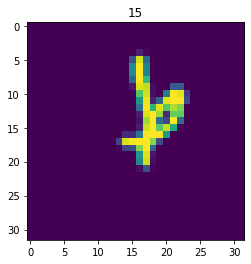

In [8]:
# visualize one of the train images and its label
plt.imshow(data[10000])
plt.title(labels[10000]);

## Data Preprocessing

In [9]:
# split data to train and validation sets
X = np.asarray(data[:])
y = np.asarray(labels[:])
x_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2,stratify=y, random_state = 80)
x_test = np.asarray(data_test[:])
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [10]:

# # building the input vector from the 32x32 pixels
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_val = x_val.reshape(x_val.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')


# normalizing the data to help with the training
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0


# one-hot encoding using keras' numpy-related utilities
n_classes = 28
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_val = np_utils.to_categorical(y_val, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

Shape before one-hot encoding:  (10752, 1)
Shape after one-hot encoding:  (10752, 28)


## CNN Model

In [11]:
# create a checkpoint to save the best model among epochs on the validation data
checkpoint = ModelCheckpoint(filepath ="./best_weight.h5",
                            monitor='val_accuracy',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

In [12]:
# building a linear stack of layers with the sequential model
model = Sequential()

# convolutional layer
model.add(Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)))

# convolutional layer
model.add(Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(200, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# flatten output of conv
model.add(Flatten())

# hidden layer
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(28, activation='softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

#model.fit(x_train, Y_train, batch_size=128, epochs=100, validation_data=(x_val, Y_val),callbacks=[checkpoint]);



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

In [13]:
# Data augmentation to create rotated, zoomed and shifted versions of the train images
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        #shear_range=0.1,          #shear images --------------------
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [14]:
# # training the model
# history = model.fit_generator(datagen.flow(x_train,Y_train, batch_size=128),
#                               epochs = 150, validation_data = (x_val,Y_val),callbacks=[checkpoint])


## Predictions

In [15]:
# load the best model saved during the training using the checkpoint
optimal_model = load_model('../input/input-file/best_weight._data_aug1_140epoch_extralayer.h5')
# recompiling the sequential model
optimal_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [16]:
# use the best model to classify the test images
y_test_predicted = optimal_model.predict(x_test)
y_classes = [np.argmax(y, axis=None, out=None)+ 1 for y in y_test_predicted]


2021-11-07 21:48:01.111154: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Text(0.5, 1.0, '25')

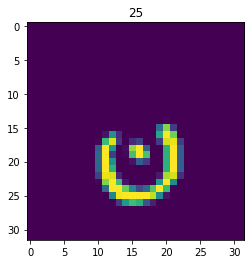

In [17]:
# check some test images manually
plt.imshow(x_test[1])
plt.title(y_classes[1])

In [18]:
# map the predicted classes of the test images to their corresponding ids
y_new = np.zeros((len(test_ids["id"].values),1),dtype = "int")
for i in range(0,len(id_test)):
    for j in range(0,len(test_ids["id"].values)):
        if id_test[i] == test_ids["id"].values[j]:
            y_new[j] = y_classes[i]

In [19]:
y_new[0:5]

array([[26],
       [10],
       [ 1],
       [10],
       [15]])

In [20]:
test_ids["label"] = y_new
test_ids["label"].value_counts().sort_index()

1     120
2     119
3     122
4     120
5     121
6     120
7     120
8     119
9     117
10    127
11    116
12    119
13    121
14    125
15    116
16    123
17    117
18    117
19    121
20    126
21    115
22    122
23    120
24    120
25    117
26    120
27    121
28    119
Name: label, dtype: int64

In [21]:
# save predictions in a submission file
test_ids[['id','label']].to_csv('./submission_final.csv', index=False)



In [22]:


# # BUILD CONVOLUTIONAL NEURAL NETWORKS
# nets = 8
# model = [0] *nets

# for j in range(8):
#     model[j] = Sequential()
#     model[j].add(Conv2D(32,kernel_size=5,activation='relu',input_shape=(32,32,1)))
#     model[j].add(MaxPool2D())
#     model[j].add(Dropout(j*0.1))
#     model[j].add(Conv2D(64,kernel_size=5,activation='relu'))
#     model[j].add(MaxPool2D())
#     model[j].add(Dropout(j*0.1))
#     model[j].add(Flatten())
#     model[j].add(Dense(128, activation='relu'))
#     model[j].add(Dropout(j*0.1))
#     model[j].add(Dense(28, activation='softmax'))
#     model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]);



In [23]:
# # TRAIN NETWORKS
# history = [0] * nets
# names = ["D=0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
# epochs = 30
# for j in range(nets):
#     history[j] = model[j].fit(x_train,y_train, batch_size=64, epochs = epochs, 
#         validation_data = (x_val,y_val), callbacks=[annealer], verbose=0)
#     print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
#         names[j],epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))